In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="BFGS",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [20]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [21]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [24]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [25]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [26]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [27]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:05,  5.15it/s]
27it [00:03,  7.14it/s]
27it [00:03,  7.17it/s]
27it [00:03,  7.31it/s]
27it [00:03,  6.81it/s]
27it [00:03,  6.89it/s]
27it [00:04,  6.51it/s]
27it [00:04,  6.48it/s]
27it [00:03,  7.11it/s]
27it [00:04,  6.73it/s]
27it [00:04,  6.69it/s]
27it [00:04,  6.35it/s]
27it [00:04,  6.29it/s]
27it [00:04,  6.55it/s]
27it [00:04,  6.53it/s]
27it [00:04,  6.22it/s]
27it [00:04,  6.63it/s]
27it [00:04,  6.45it/s]
27it [00:03,  6.95it/s]
27it [00:03,  6.92it/s]
27it [00:03,  6.96it/s]
27it [00:04,  6.29it/s]
27it [00:04,  6.53it/s]
27it [00:03,  7.23it/s]
27it [00:03,  7.36it/s]
27it [00:03,  7.15it/s]
27it [00:03,  6.91it/s]
27it [00:03,  7.36it/s]
27it [00:03,  7.16it/s]
27it [00:03,  7.09it/s]
27it [00:03,  7.38it/s]
27it [00:03,  7.08it/s]
27it [00:03,  6.82it/s]
27it [00:03,  7.13it/s]
27it [00:03,  7.06it/s]
27it [00:03,  7.31it/s]
27it [00:03,  7.90it/s]
27it [00:03,  7.48it/s]
27it [00:03,  7.82it/s]
27it [00:03,  7.72it/s]
27it [00:03,  7.49it/s]
27it [00:03,  7.

27it [00:03,  8.04it/s]
27it [00:03,  7.98it/s]
27it [00:03,  7.99it/s]
27it [00:03,  7.60it/s]
27it [00:03,  7.56it/s]
27it [00:03,  7.93it/s]
27it [00:03,  7.99it/s]
27it [00:03,  7.99it/s]
27it [00:03,  7.91it/s]
27it [00:03,  7.93it/s]
27it [00:03,  7.87it/s]
27it [00:03,  7.72it/s]
27it [00:03,  8.16it/s]
27it [00:03,  7.94it/s]
27it [00:03,  7.84it/s]
27it [00:03,  7.94it/s]
27it [00:03,  7.81it/s]
27it [00:03,  8.13it/s]
27it [00:03,  8.43it/s]
27it [00:03,  8.47it/s]
27it [00:03,  8.37it/s]
27it [00:03,  8.47it/s]
27it [00:03,  8.39it/s]
27it [00:03,  8.29it/s]
27it [00:03,  8.10it/s]
27it [00:03,  8.33it/s]
27it [00:03,  8.40it/s]
27it [00:03,  8.33it/s]
27it [00:03,  8.08it/s]
27it [00:03,  8.00it/s]
27it [00:03,  8.29it/s]
27it [00:03,  8.08it/s]
27it [00:03,  8.20it/s]
27it [00:03,  7.86it/s]
27it [00:03,  8.25it/s]
27it [00:03,  7.72it/s]
27it [00:03,  8.15it/s]
27it [00:03,  8.01it/s]
27it [00:03,  8.28it/s]
27it [00:03,  7.76it/s]
27it [00:03,  7.92it/s]
27it [00:03,  8.

27it [00:03,  7.67it/s]
27it [00:03,  7.55it/s]
27it [00:03,  7.57it/s]
27it [00:03,  7.57it/s]
27it [00:03,  7.22it/s]
27it [00:03,  7.58it/s]
27it [00:03,  7.53it/s]
27it [00:03,  7.54it/s]
27it [00:03,  7.66it/s]
27it [00:03,  7.36it/s]
27it [00:03,  7.60it/s]
27it [00:03,  7.38it/s]
27it [00:03,  7.41it/s]
27it [00:03,  7.31it/s]
27it [00:03,  7.46it/s]
27it [00:03,  7.68it/s]
27it [00:03,  7.70it/s]
27it [00:03,  7.69it/s]
27it [00:03,  7.93it/s]
27it [00:03,  7.72it/s]
27it [00:03,  8.25it/s]
27it [00:03,  7.78it/s]
27it [00:03,  7.87it/s]
27it [00:03,  7.87it/s]
27it [00:03,  7.77it/s]
27it [00:03,  8.16it/s]
27it [00:03,  7.95it/s]
27it [00:03,  7.85it/s]
27it [00:03,  7.86it/s]
27it [00:03,  7.98it/s]
27it [00:03,  7.61it/s]
27it [00:03,  8.02it/s]
27it [00:03,  8.26it/s]
27it [00:03,  8.04it/s]
27it [00:03,  8.21it/s]
27it [00:03,  7.98it/s]
27it [00:03,  8.07it/s]
27it [00:03,  7.93it/s]
27it [00:03,  7.84it/s]
27it [00:03,  7.97it/s]
27it [00:03,  8.10it/s]
27it [00:03,  7.

         Current function value: -7.509209
         Iterations: 3
         Function evaluations: 935
         Gradient evaluations: 28
[3.73532055 4.57861248 4.72369068 1.12305568 6.18885322 2.46667533
 2.39022462 0.33418681 6.14300136 1.78458887 3.68726634 6.17357252
 4.06429322 2.15471966 1.2128247  3.415026   4.18255341 4.26144396
 3.65204922 5.85647284 4.47352254 3.57260165 4.10258275 4.20931773
 4.74626699 0.19523815 2.16741    2.14317238 0.89902741 3.22129587
 0.01556023 5.8391126 ]


27it [00:03,  7.89it/s]

CPU times: total: 50min
Wall time: 53min 57s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.5048414031974815

Approximation Error
0.04552233065981738


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


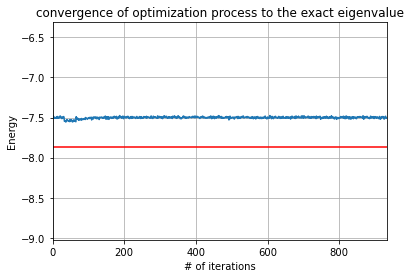

In [28]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [29]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:03,  7.67it/s]
27it [00:03,  7.36it/s]
27it [00:03,  7.84it/s]
27it [00:03,  7.48it/s]
27it [00:03,  7.97it/s]
27it [00:03,  7.58it/s]
27it [00:03,  7.51it/s]
27it [00:03,  7.64it/s]
27it [00:03,  7.53it/s]
27it [00:03,  7.67it/s]
27it [00:03,  7.70it/s]
27it [00:03,  7.48it/s]
27it [00:03,  7.28it/s]
27it [00:03,  7.95it/s]
27it [00:03,  7.86it/s]
27it [00:03,  7.61it/s]
27it [00:03,  8.13it/s]
27it [00:03,  7.61it/s]
27it [00:03,  7.49it/s]
27it [00:03,  7.95it/s]
27it [00:03,  7.72it/s]
27it [00:03,  7.41it/s]
27it [00:03,  7.19it/s]
27it [00:03,  7.53it/s]
27it [00:03,  7.33it/s]
27it [00:03,  7.78it/s]
27it [00:03,  8.01it/s]
27it [00:03,  7.54it/s]
27it [00:03,  7.64it/s]
27it [00:03,  7.90it/s]
27it [00:03,  7.54it/s]
27it [00:03,  7.78it/s]
27it [00:03,  7.90it/s]
27it [00:03,  7.76it/s]
27it [00:03,  7.60it/s]
27it [00:03,  7.58it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.51it/s]
27it [00:03,  8.26it/s]
27it [00:03,  7.39it/s]
27it [00:03,  7.69it/s]
27it [00:03,  7.

27it [00:04,  6.72it/s]
27it [00:04,  6.37it/s]
27it [00:04,  6.21it/s]
27it [00:04,  5.84it/s]
27it [00:04,  5.91it/s]
27it [00:04,  5.59it/s]
27it [00:04,  5.77it/s]
27it [00:05,  5.20it/s]
27it [00:04,  6.15it/s]
27it [00:04,  6.15it/s]
27it [00:04,  5.71it/s]
27it [00:04,  5.69it/s]
27it [00:04,  5.55it/s]
27it [00:04,  5.91it/s]
27it [00:04,  5.85it/s]
27it [00:04,  5.58it/s]
27it [00:04,  6.14it/s]
27it [00:04,  6.52it/s]
27it [00:04,  5.52it/s]
27it [00:04,  5.86it/s]
27it [00:04,  5.75it/s]
27it [00:04,  5.56it/s]
27it [00:04,  5.88it/s]
27it [00:05,  5.29it/s]
27it [00:04,  5.81it/s]
27it [00:04,  6.00it/s]
27it [00:04,  5.87it/s]
27it [00:04,  5.83it/s]
27it [00:04,  5.86it/s]
27it [00:04,  5.82it/s]
27it [00:04,  5.73it/s]
27it [00:04,  5.88it/s]
27it [00:04,  6.06it/s]
27it [00:04,  6.09it/s]
27it [00:04,  5.95it/s]
27it [00:04,  5.83it/s]
27it [00:04,  5.86it/s]
27it [00:04,  5.93it/s]
27it [00:04,  6.06it/s]
27it [00:04,  5.70it/s]
27it [00:04,  5.70it/s]
27it [00:04,  5.

27it [00:03,  8.04it/s]
27it [00:03,  8.46it/s]
27it [00:03,  8.16it/s]
27it [00:03,  8.04it/s]
27it [00:03,  7.86it/s]
27it [00:02,  9.28it/s]
27it [00:03,  7.91it/s]
27it [00:02,  9.12it/s]
27it [00:03,  8.29it/s]
27it [00:03,  8.95it/s]
27it [00:03,  8.85it/s]
27it [00:03,  8.79it/s]
27it [00:03,  8.44it/s]
27it [00:02,  9.04it/s]
27it [00:03,  7.87it/s]
27it [00:03,  8.81it/s]
27it [00:03,  8.56it/s]
27it [00:03,  8.66it/s]
27it [00:03,  8.79it/s]
27it [00:02,  9.40it/s]
27it [00:03,  8.60it/s]
27it [00:03,  8.85it/s]
27it [00:03,  8.59it/s]
27it [00:03,  8.39it/s]
27it [00:02,  9.44it/s]
27it [00:02,  9.29it/s]
27it [00:03,  8.48it/s]
27it [00:03,  8.34it/s]
27it [00:03,  8.64it/s]
27it [00:03,  8.04it/s]
27it [00:03,  8.71it/s]
27it [00:03,  8.10it/s]
27it [00:03,  8.12it/s]
27it [00:03,  8.30it/s]
27it [00:03,  8.35it/s]
27it [00:03,  8.70it/s]
27it [00:03,  8.68it/s]
27it [00:03,  8.53it/s]
27it [00:02,  9.31it/s]
27it [00:03,  8.81it/s]
27it [00:03,  8.17it/s]
27it [00:03,  8.

Divide-by-zero encountered: rhok assumed large


27it [00:03,  7.96it/s]
27it [00:02,  9.38it/s]
27it [00:03,  8.09it/s]
27it [00:03,  8.20it/s]
27it [00:02,  9.15it/s]
27it [00:03,  8.80it/s]
27it [00:02,  9.03it/s]
27it [00:03,  8.71it/s]
27it [00:03,  7.86it/s]
27it [00:02,  9.11it/s]
27it [00:03,  8.72it/s]
27it [00:02,  9.48it/s]
27it [00:02, 10.37it/s]
27it [00:02,  9.58it/s]
27it [00:03,  8.49it/s]
27it [00:03,  8.53it/s]
27it [00:03,  8.49it/s]
27it [00:03,  8.88it/s]
27it [00:03,  8.04it/s]
27it [00:03,  8.58it/s]
27it [00:03,  8.40it/s]
27it [00:03,  8.60it/s]
27it [00:03,  8.61it/s]
27it [00:03,  8.55it/s]
27it [00:03,  8.40it/s]
27it [00:02, 10.29it/s]
27it [00:03,  8.66it/s]
27it [00:03,  8.29it/s]
27it [00:03,  8.47it/s]
27it [00:03,  8.72it/s]
27it [00:03,  8.88it/s]
27it [00:03,  7.75it/s]
27it [00:03,  8.66it/s]
27it [00:03,  8.55it/s]
27it [00:02, 10.40it/s]
27it [00:02, 10.32it/s]
27it [00:03,  8.98it/s]
27it [00:03,  8.01it/s]
27it [00:03,  8.05it/s]
27it [00:02,  9.38it/s]
27it [00:03,  8.40it/s]
27it [00:03,  8.

         Current function value: -7.592947
         Iterations: 4
         Function evaluations: 1079
         Gradient evaluations: 32
[4.22480304 4.57100324 4.07475047 0.71986732 1.31582524 5.63720043
 6.17339636 0.9941041  0.11075202 5.02644321 2.30542362 4.87129735
 4.34195053 1.37349584 0.54339924 3.53541554 4.2473489  5.63453418
 4.68629267 4.7317256  3.33197948 4.44216282 1.89845186 2.04632721
 2.63767401 1.57954106 2.68355348 1.4416769  1.73467366 3.53402629
 0.7577518  1.95959002]


27it [00:03,  8.28it/s]

CPU times: total: 58min 30s
Wall time: 1h 9min 40s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.586476157378188

Approximation Error
0.03513989274789004


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


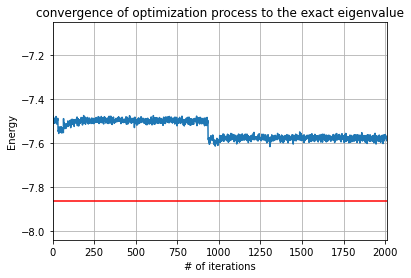

In [30]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [31]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [32]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:01,  7.83it/s]
15it [00:01,  8.25it/s]
15it [00:01,  8.85it/s]
15it [00:01,  8.28it/s]
15it [00:01,  9.59it/s]
15it [00:01,  9.02it/s]
15it [00:01,  8.55it/s]
15it [00:01, 10.28it/s]
15it [00:01,  9.77it/s]
15it [00:01,  8.38it/s]
15it [00:01,  8.96it/s]
15it [00:01,  9.38it/s]
15it [00:01,  9.50it/s]
15it [00:01, 10.91it/s]
15it [00:01, 11.27it/s]
15it [00:01, 11.11it/s]
15it [00:01,  9.89it/s]
15it [00:01,  8.51it/s]
15it [00:01,  8.96it/s]
15it [00:01,  9.42it/s]
15it [00:01,  7.69it/s]
15it [00:02,  7.44it/s]
15it [00:01,  7.80it/s]
15it [00:01,  8.88it/s]
15it [00:01,  8.72it/s]
15it [00:01,  8.85it/s]
15it [00:02,  7.31it/s]
15it [00:01,  8.53it/s]
15it [00:01,  7.97it/s]
15it [00:01,  8.42it/s]
15it [00:01,  8.71it/s]
15it [00:01, 10.13it/s]
15it [00:01,  8.74it/s]
15it [00:01,  8.57it/s]
15it [00:01,  8.64it/s]
15it [00:01,  8.35it/s]
15it [00:01,  8.30it/s]
15it [00:01,  8.55it/s]
15it [00:01,  8.70it/s]
15it [00:01,  8.16it/s]
15it [00:01,  8.48it/s]
15it [00:01,  8.

15it [00:01,  8.03it/s]
15it [00:01,  8.60it/s]
15it [00:01,  9.98it/s]
15it [00:01,  9.83it/s]
15it [00:01,  9.53it/s]
15it [00:01,  9.02it/s]
15it [00:01,  8.82it/s]
15it [00:01,  9.56it/s]
15it [00:01,  9.06it/s]
15it [00:01,  8.47it/s]
15it [00:01,  9.26it/s]
15it [00:01,  9.24it/s]
15it [00:01,  9.21it/s]
15it [00:01,  8.49it/s]
15it [00:01,  8.91it/s]
15it [00:01,  8.54it/s]
15it [00:01,  8.32it/s]
15it [00:01,  8.82it/s]
15it [00:01,  8.46it/s]
15it [00:01,  8.48it/s]
15it [00:01,  8.47it/s]
15it [00:01,  9.64it/s]
15it [00:01,  8.51it/s]
15it [00:01,  9.52it/s]
15it [00:01,  8.44it/s]
15it [00:01,  8.17it/s]
15it [00:01,  9.27it/s]
15it [00:01,  8.93it/s]
15it [00:01,  9.14it/s]
15it [00:01,  8.77it/s]
15it [00:01,  8.92it/s]
15it [00:01,  9.72it/s]
15it [00:01,  9.97it/s]
15it [00:01,  9.38it/s]
15it [00:01,  8.57it/s]
15it [00:01,  8.98it/s]
15it [00:01,  8.58it/s]
15it [00:01,  7.75it/s]
15it [00:01,  8.19it/s]
15it [00:01,  8.73it/s]
15it [00:01,  9.84it/s]
15it [00:01,  8.

         Current function value: -0.628405
         Iterations: 1
         Function evaluations: 638
         Gradient evaluations: 19
[4.70633225 0.01058821 2.68532504 1.81376135 3.14363705 3.16567942
 1.63884883 5.51904793 2.31952242 6.12640906 5.48475432 1.69252577
 6.2670699  4.52984334 2.80814303 2.03275117 1.38099552 0.81813583
 0.42789396 2.70116898 1.09470971 1.22558831 3.59839059 1.90945796
 2.83049541 5.30430451 2.7865628  6.22818135 5.05850132 1.23913038
 4.64077692 1.6347765 ]


15it [00:01,  8.63it/s]

CPU times: total: 17min 35s
Wall time: 1h 42min 17s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.5818335260018374

Approximation Error
0.6867273201113152


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


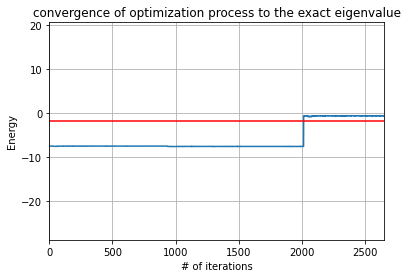

In [33]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [34]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:01,  8.24it/s]
15it [00:02,  6.86it/s]
15it [00:01,  8.00it/s]
15it [00:02,  7.32it/s]
15it [00:02,  7.12it/s]
15it [00:01,  8.52it/s]
15it [00:01,  8.26it/s]
15it [00:01,  8.62it/s]
15it [00:02,  7.44it/s]
15it [00:01,  7.90it/s]
15it [00:02,  7.20it/s]
15it [00:01,  7.58it/s]
15it [00:01,  8.71it/s]
15it [00:01,  7.81it/s]
15it [00:01,  8.23it/s]
15it [00:02,  6.51it/s]
15it [00:02,  7.31it/s]
15it [00:02,  5.56it/s]
15it [00:02,  6.79it/s]
15it [00:02,  6.98it/s]
15it [00:02,  7.37it/s]
15it [00:01,  7.51it/s]
15it [00:01,  7.74it/s]
15it [00:02,  6.66it/s]
15it [00:02,  6.39it/s]
15it [00:02,  6.02it/s]
15it [00:02,  6.57it/s]
15it [00:02,  6.62it/s]
15it [00:02,  7.18it/s]
15it [00:02,  7.24it/s]
15it [00:02,  7.18it/s]
15it [00:01,  7.92it/s]
15it [00:02,  7.36it/s]
15it [00:02,  6.64it/s]
15it [00:02,  7.12it/s]
15it [00:01,  7.88it/s]
15it [00:01,  8.34it/s]
15it [00:01,  9.26it/s]
15it [00:02,  7.31it/s]
15it [00:01,  7.82it/s]
15it [00:01,  7.89it/s]
15it [00:02,  6.

15it [00:01,  7.62it/s]
15it [00:01,  8.24it/s]
15it [00:01,  8.17it/s]
15it [00:01,  8.28it/s]
15it [00:01,  7.53it/s]
15it [00:01,  7.53it/s]
15it [00:01,  7.97it/s]
15it [00:01,  7.91it/s]
15it [00:01,  7.77it/s]
15it [00:01,  7.92it/s]
15it [00:02,  7.50it/s]
15it [00:01,  7.55it/s]
15it [00:01,  8.68it/s]
15it [00:01,  7.55it/s]
15it [00:02,  6.75it/s]
15it [00:01,  7.53it/s]
15it [00:02,  6.59it/s]
15it [00:02,  6.39it/s]
15it [00:02,  5.86it/s]
15it [00:02,  5.77it/s]
15it [00:02,  5.45it/s]
15it [00:03,  4.82it/s]
15it [00:02,  5.88it/s]
15it [00:02,  6.83it/s]
15it [00:02,  6.85it/s]
15it [00:02,  6.88it/s]
15it [00:02,  6.74it/s]
15it [00:02,  6.96it/s]
15it [00:02,  6.39it/s]
15it [00:02,  7.09it/s]
15it [00:02,  6.93it/s]
15it [00:02,  6.99it/s]
15it [00:02,  6.90it/s]
15it [00:02,  6.93it/s]
15it [00:02,  6.93it/s]
15it [00:01,  8.38it/s]
15it [00:01,  7.89it/s]
15it [00:02,  6.56it/s]
15it [00:02,  7.40it/s]
15it [00:02,  6.87it/s]
15it [00:01,  7.84it/s]
15it [00:01,  7.

15it [00:02,  7.08it/s]
15it [00:02,  7.07it/s]
15it [00:02,  6.67it/s]
15it [00:02,  6.98it/s]
15it [00:02,  7.16it/s]
15it [00:02,  7.23it/s]
15it [00:01,  7.51it/s]
15it [00:02,  6.82it/s]
15it [00:02,  6.75it/s]
15it [00:02,  6.94it/s]
15it [00:02,  7.45it/s]
15it [00:02,  7.38it/s]
15it [00:01,  8.05it/s]
15it [00:02,  6.70it/s]
15it [00:02,  5.74it/s]
15it [00:02,  6.17it/s]
15it [00:02,  6.42it/s]
15it [00:02,  6.41it/s]
15it [00:02,  6.24it/s]
15it [00:02,  6.03it/s]
15it [00:02,  5.36it/s]
15it [00:02,  5.76it/s]
15it [00:02,  5.71it/s]
15it [00:02,  6.09it/s]
15it [00:02,  6.54it/s]
15it [00:02,  6.38it/s]
15it [00:02,  6.85it/s]
15it [00:02,  6.46it/s]
15it [00:02,  6.66it/s]
15it [00:02,  6.43it/s]
15it [00:02,  6.62it/s]
15it [00:02,  6.62it/s]
15it [00:02,  6.90it/s]
15it [00:02,  6.95it/s]
15it [00:02,  6.67it/s]
15it [00:02,  6.07it/s]
15it [00:02,  6.81it/s]
15it [00:02,  7.49it/s]
15it [00:01,  7.64it/s]
15it [00:02,  6.90it/s]
15it [00:02,  5.46it/s]
15it [00:02,  6.

         Current function value: -0.850473
         Iterations: 2
         Function evaluations: 739
         Gradient evaluations: 22
[5.65739628 2.41584097 3.11132856 4.13673607 3.97746106 4.75217178
 1.64110225 3.34398982 2.27029744 4.61283031 2.59593654 5.68212976
 1.45939396 5.43430532 0.68187045 4.54027013 3.91600698 2.35440668
 5.58569685 5.16002596 4.40424914 2.32141781 6.24534519 4.33079168
 2.77020665 3.61975593 1.65904475 1.58938205 3.74373756 5.24197518
 4.58398399 2.50447734]


15it [00:02,  5.93it/s]

CPU times: total: 22min 18s
Wall time: 24min 21s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.8213106360756347

Approximation Error
0.5577872836710995


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


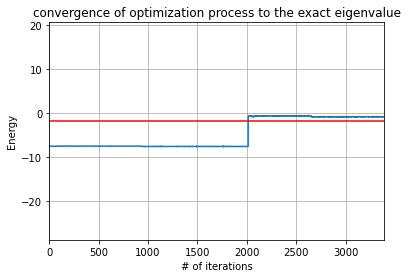

In [35]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [36]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [37]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  6.29it/s]
11it [00:01,  6.55it/s]
11it [00:01,  6.69it/s]
11it [00:01,  6.46it/s]
11it [00:01,  6.59it/s]
11it [00:01,  6.10it/s]
11it [00:01,  6.38it/s]
11it [00:01,  6.68it/s]
11it [00:01,  6.81it/s]
11it [00:01,  6.17it/s]
11it [00:01,  7.24it/s]
11it [00:01,  6.37it/s]
11it [00:01,  6.65it/s]
11it [00:01,  6.73it/s]
11it [00:01,  6.29it/s]
11it [00:01,  6.41it/s]
11it [00:01,  6.53it/s]
11it [00:01,  6.19it/s]
11it [00:01,  6.71it/s]
11it [00:01,  6.37it/s]
11it [00:01,  7.34it/s]
11it [00:01,  7.34it/s]
11it [00:01,  7.38it/s]
11it [00:01,  6.54it/s]
11it [00:01,  7.32it/s]
11it [00:01,  6.99it/s]
11it [00:01,  6.64it/s]
11it [00:01,  6.88it/s]
11it [00:01,  6.59it/s]
11it [00:01,  6.56it/s]
11it [00:01,  7.32it/s]
11it [00:01,  6.35it/s]
11it [00:01,  7.20it/s]
11it [00:01,  6.88it/s]
11it [00:01,  6.90it/s]
11it [00:01,  6.58it/s]
11it [00:01,  6.25it/s]
11it [00:01,  6.04it/s]
11it [00:01,  6.21it/s]
11it [00:01,  6.78it/s]
11it [00:01,  6.79it/s]
11it [00:01,  7.

11it [00:01,  6.02it/s]
11it [00:01,  6.43it/s]
11it [00:01,  5.87it/s]
11it [00:01,  5.91it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.24it/s]
11it [00:01,  5.93it/s]
11it [00:01,  6.30it/s]
11it [00:01,  6.28it/s]
11it [00:01,  5.78it/s]
11it [00:01,  6.38it/s]
11it [00:01,  5.85it/s]
11it [00:01,  6.44it/s]
11it [00:01,  5.87it/s]
11it [00:01,  5.53it/s]
11it [00:01,  5.77it/s]
11it [00:01,  6.08it/s]
11it [00:02,  5.44it/s]
11it [00:01,  5.93it/s]
11it [00:01,  6.03it/s]
11it [00:01,  6.01it/s]
11it [00:01,  6.55it/s]
11it [00:01,  6.28it/s]
11it [00:01,  6.14it/s]
11it [00:01,  6.07it/s]
11it [00:01,  6.49it/s]
11it [00:01,  6.52it/s]
11it [00:01,  6.92it/s]
11it [00:01,  5.74it/s]
11it [00:01,  6.70it/s]
11it [00:01,  6.87it/s]
11it [00:01,  6.66it/s]
11it [00:01,  8.06it/s]
11it [00:01,  6.69it/s]
11it [00:01,  6.37it/s]
11it [00:01,  6.63it/s]
11it [00:01,  6.28it/s]
11it [00:01,  6.73it/s]
11it [00:01,  6.42it/s]
11it [00:01,  6.53it/s]
11it [00:01,  6.

11it [00:01,  9.34it/s]
11it [00:01, 11.00it/s]
11it [00:00, 11.35it/s]
11it [00:01,  8.54it/s]
11it [00:01,  8.95it/s]
11it [00:01,  8.64it/s]
11it [00:01,  8.63it/s]
11it [00:01,  9.38it/s]
11it [00:01,  9.06it/s]
11it [00:01,  9.36it/s]
11it [00:01, 10.06it/s]
11it [00:01,  8.93it/s]
11it [00:01,  9.26it/s]
11it [00:01,  9.96it/s]
11it [00:00, 11.07it/s]
11it [00:01, 10.00it/s]
11it [00:01,  9.15it/s]
11it [00:01,  9.36it/s]
11it [00:01,  9.44it/s]
11it [00:01, 10.18it/s]
11it [00:01,  9.81it/s]
11it [00:01, 10.68it/s]
11it [00:01,  8.79it/s]
11it [00:01, 10.58it/s]
11it [00:01,  9.15it/s]
11it [00:01,  9.90it/s]
11it [00:01,  9.62it/s]
11it [00:01, 10.27it/s]
11it [00:01,  9.21it/s]
11it [00:01,  9.79it/s]
11it [00:01, 10.55it/s]
11it [00:01,  9.39it/s]
11it [00:01,  8.77it/s]
11it [00:01,  9.87it/s]
11it [00:01,  9.80it/s]
11it [00:01,  9.56it/s]
11it [00:01,  9.16it/s]
11it [00:01, 10.19it/s]
11it [00:01,  8.82it/s]
11it [00:01, 10.22it/s]
11it [00:01,  8.63it/s]
11it [00:01, 10.

         Current function value: 0.487335
         Iterations: 4
         Function evaluations: 1012
         Gradient evaluations: 30
[1.62434559 4.24114859 4.80478949 4.68926203 1.83185581 5.69516137
 1.13613    3.12492256 0.20557807 1.43301756 3.59107089 4.2764387
 4.22069302 6.24914259 5.31326816 5.70418805 5.30821438 2.62367135
 4.30892068 1.59488166 1.92591668 2.31600572 4.55546281 5.57824595
 1.92252521 1.36214338 2.88372126 4.60575447 3.85790217 1.66449886
 4.21929135 1.1984359 ]


11it [00:01,  6.02it/s]

CPU times: total: 24min 6s
Wall time: 26min 13s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
0.605086195580291

Approximation Error
0.6973790650842336


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


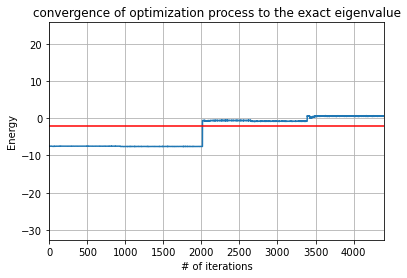

In [38]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [39]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  6.31it/s]
11it [00:01,  6.30it/s]
11it [00:01,  6.53it/s]
11it [00:01,  6.20it/s]
11it [00:01,  6.78it/s]
11it [00:01,  6.26it/s]
11it [00:01,  5.63it/s]
11it [00:01,  6.86it/s]
11it [00:01,  6.36it/s]
11it [00:01,  6.45it/s]
11it [00:01,  6.54it/s]
11it [00:01,  5.79it/s]
11it [00:01,  5.97it/s]
11it [00:01,  6.27it/s]
11it [00:01,  5.86it/s]
11it [00:01,  6.22it/s]
11it [00:01,  6.43it/s]
11it [00:01,  6.54it/s]
11it [00:01,  6.11it/s]
11it [00:01,  6.86it/s]
11it [00:01,  6.07it/s]
11it [00:01,  6.90it/s]
11it [00:01,  7.11it/s]
11it [00:01,  6.68it/s]
11it [00:01,  6.71it/s]
11it [00:01,  6.50it/s]
11it [00:01,  6.75it/s]
11it [00:01,  7.53it/s]
11it [00:01,  7.34it/s]
11it [00:01,  6.59it/s]
11it [00:01,  7.05it/s]
11it [00:01,  7.77it/s]
11it [00:01,  6.61it/s]
11it [00:01,  7.05it/s]
11it [00:01,  7.10it/s]
11it [00:01,  7.56it/s]
11it [00:01,  6.30it/s]
11it [00:01,  7.15it/s]
11it [00:01,  7.12it/s]
11it [00:01,  7.53it/s]
11it [00:01,  7.39it/s]
11it [00:01,  6.

11it [00:01,  7.08it/s]
11it [00:01,  7.21it/s]
11it [00:01,  7.87it/s]
11it [00:01,  7.70it/s]
11it [00:01,  7.20it/s]
11it [00:01,  7.31it/s]
11it [00:01,  7.43it/s]
11it [00:01,  7.79it/s]
11it [00:01,  6.74it/s]
11it [00:01,  7.08it/s]
11it [00:01,  7.24it/s]
11it [00:01,  7.27it/s]
11it [00:01,  5.84it/s]
11it [00:01,  6.09it/s]
11it [00:01,  7.23it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.66it/s]
11it [00:01,  6.62it/s]
11it [00:01,  7.16it/s]
11it [00:01,  6.70it/s]
11it [00:01,  6.97it/s]
11it [00:01,  7.17it/s]
11it [00:01,  6.54it/s]
11it [00:01,  6.47it/s]
11it [00:01,  6.64it/s]
11it [00:01,  6.25it/s]
11it [00:01,  6.28it/s]
11it [00:01,  6.72it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.24it/s]
11it [00:01,  6.48it/s]
11it [00:01,  5.89it/s]
11it [00:01,  6.62it/s]
11it [00:01,  6.17it/s]
11it [00:01,  6.37it/s]
11it [00:01,  6.64it/s]
11it [00:01,  6.54it/s]
11it [00:01,  5.90it/s]
11it [00:01,  6.30it/s]
11it [00:01,  6.18it/s]
11it [00:01,  6.17it/s]
11it [00:01,  6.

11it [00:01,  7.35it/s]
11it [00:01,  7.57it/s]
11it [00:01,  6.95it/s]
11it [00:01,  7.95it/s]
11it [00:01,  8.03it/s]
11it [00:01,  7.87it/s]
11it [00:01,  7.51it/s]
11it [00:01,  8.53it/s]
11it [00:01,  7.51it/s]
11it [00:01,  7.58it/s]
11it [00:01,  7.83it/s]
11it [00:01,  8.25it/s]
11it [00:01,  7.28it/s]
11it [00:01,  8.38it/s]
11it [00:01,  7.29it/s]
11it [00:01,  7.42it/s]
11it [00:01,  6.87it/s]
11it [00:01,  8.00it/s]
11it [00:01,  6.71it/s]
11it [00:01,  7.50it/s]
11it [00:01,  9.14it/s]
11it [00:01,  8.09it/s]
11it [00:01,  7.49it/s]
11it [00:01,  6.30it/s]
11it [00:01,  8.17it/s]
11it [00:01,  7.21it/s]
11it [00:01,  8.48it/s]
11it [00:01,  8.02it/s]
11it [00:01,  8.04it/s]
11it [00:01,  7.29it/s]
11it [00:01,  7.32it/s]
11it [00:01,  9.28it/s]
11it [00:01,  8.65it/s]
11it [00:01,  6.86it/s]
11it [00:02,  4.89it/s]
11it [00:01,  6.75it/s]
11it [00:01,  7.94it/s]
11it [00:01,  9.10it/s]
11it [00:01,  8.59it/s]
11it [00:01,  7.68it/s]
11it [00:01,  8.70it/s]
11it [00:01,  6.

         Current function value: 0.065673
         Iterations: 4
         Function evaluations: 870
         Gradient evaluations: 26
[5.45174509 2.11586853 5.87706883 4.90630584 0.25782334 2.22238373
 1.31512331 3.07417091 2.09377716 3.3552022  2.80024247 2.51461805
 1.95031179 0.988913   2.58009609 5.95375821 4.46378748 0.54075161
 2.49375521 4.0707453  1.09863873 4.82607743 4.30133887 1.67083672
 0.0378213  5.88472528 0.1620777  1.4229711  5.36479745 5.66608599
 1.52744738 5.439919  ]


11it [00:01, 10.95it/s]

CPU times: total: 19min 23s
Wall time: 21min 2s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
0.09541991585001017

Approximation Error
0.9522777674403544


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


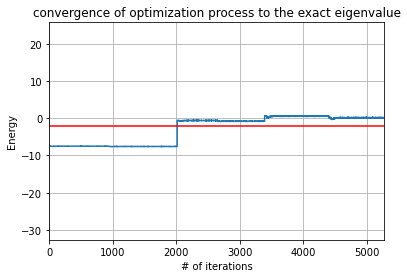

In [40]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [41]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [42]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [43]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00, 12.96it/s]
7it [00:00, 15.95it/s]
7it [00:00, 14.93it/s]
7it [00:00, 17.74it/s]
7it [00:00, 15.18it/s]
7it [00:00, 12.37it/s]
7it [00:00, 15.45it/s]
7it [00:00, 17.01it/s]
7it [00:00, 15.74it/s]
7it [00:00, 17.14it/s]
7it [00:00, 14.64it/s]
7it [00:00, 17.15it/s]
7it [00:00, 16.17it/s]
7it [00:00, 14.68it/s]
7it [00:00, 15.80it/s]
7it [00:00, 17.97it/s]
7it [00:00, 14.08it/s]
7it [00:00, 13.45it/s]
7it [00:00, 13.86it/s]
7it [00:00, 13.39it/s]
7it [00:00, 12.48it/s]
7it [00:00, 12.44it/s]
7it [00:00, 13.05it/s]
7it [00:00, 12.58it/s]
7it [00:00, 14.35it/s]
7it [00:00, 13.23it/s]
7it [00:00, 15.53it/s]
7it [00:00, 13.02it/s]
7it [00:00, 12.83it/s]
7it [00:00, 13.08it/s]
7it [00:00, 12.53it/s]
7it [00:00, 12.22it/s]
7it [00:00, 13.88it/s]
7it [00:00, 11.99it/s]
7it [00:00, 15.95it/s]
7it [00:00, 13.91it/s]
7it [00:00, 13.22it/s]
7it [00:00, 14.00it/s]
7it [00:00, 12.60it/s]
7it [00:00, 10.63it/s]
7it [00:00, 15.20it/s]
7it [00:00, 15.76it/s]
7it [00:00, 14.45it/s]
7it [00:00,

7it [00:00, 21.85it/s]
7it [00:00, 16.63it/s]
7it [00:00, 20.55it/s]
7it [00:00, 19.66it/s]
7it [00:00, 16.53it/s]
7it [00:00, 21.16it/s]
7it [00:00, 15.47it/s]
7it [00:00, 16.97it/s]
7it [00:00, 19.28it/s]
7it [00:00, 19.52it/s]
7it [00:00, 19.84it/s]
7it [00:00, 17.85it/s]
7it [00:00, 22.36it/s]
7it [00:00, 18.49it/s]
7it [00:00, 23.57it/s]
7it [00:00, 21.86it/s]
7it [00:00, 21.87it/s]
7it [00:00, 19.28it/s]
7it [00:00, 18.55it/s]
7it [00:00, 20.26it/s]
7it [00:00, 18.76it/s]
7it [00:00, 23.56it/s]
7it [00:00, 19.23it/s]
7it [00:00, 20.52it/s]
7it [00:00, 19.21it/s]
7it [00:00, 19.73it/s]
7it [00:00, 17.49it/s]
7it [00:00, 20.51it/s]
7it [00:00, 18.50it/s]
7it [00:00, 19.81it/s]
7it [00:00, 18.97it/s]
7it [00:00, 18.65it/s]
7it [00:00, 19.48it/s]
7it [00:00, 20.51it/s]
7it [00:00, 17.39it/s]
7it [00:00, 19.00it/s]
7it [00:00, 18.38it/s]
7it [00:00, 17.06it/s]
7it [00:00, 18.75it/s]
7it [00:00, 19.73it/s]
7it [00:00, 16.38it/s]
7it [00:00, 18.89it/s]
7it [00:00, 18.00it/s]
7it [00:00,

7it [00:00, 11.54it/s]
7it [00:00, 12.51it/s]
7it [00:00, 11.29it/s]
7it [00:00, 10.07it/s]
7it [00:00, 11.43it/s]
7it [00:00, 10.81it/s]
7it [00:00,  8.44it/s]
7it [00:00,  9.20it/s]
7it [00:00,  8.23it/s]
7it [00:00,  9.45it/s]
7it [00:00,  7.46it/s]
7it [00:00,  8.88it/s]
7it [00:00,  9.19it/s]
7it [00:00, 10.49it/s]
7it [00:00,  9.67it/s]
7it [00:00, 11.26it/s]
7it [00:00, 12.91it/s]
7it [00:00, 11.80it/s]
7it [00:00, 11.34it/s]
7it [00:00, 11.45it/s]
7it [00:00, 11.97it/s]
7it [00:00, 11.28it/s]
7it [00:00, 12.42it/s]
7it [00:00, 12.09it/s]
7it [00:00, 13.52it/s]
7it [00:00, 13.92it/s]
7it [00:00, 14.97it/s]
7it [00:00, 13.06it/s]
7it [00:00, 12.38it/s]
7it [00:00, 13.16it/s]
7it [00:00, 14.46it/s]
7it [00:00, 12.75it/s]
7it [00:00, 12.14it/s]
7it [00:00, 14.13it/s]
7it [00:00, 12.49it/s]
7it [00:00, 11.57it/s]
7it [00:00, 12.01it/s]
7it [00:00, 12.34it/s]
7it [00:00, 12.65it/s]
7it [00:00, 13.90it/s]
7it [00:00, 12.31it/s]
7it [00:00, 10.24it/s]
7it [00:00, 11.70it/s]
7it [00:00,

         Current function value: 0.197717
         Iterations: 7
         Function evaluations: 900
         Gradient evaluations: 35
[2.61294557 5.17682619 2.65185816 2.40428204 0.59663149 0.92952966
 1.54250456 0.20754472 4.55688941 5.71121315 2.65416761 1.77305918
 5.98700256 2.29409058 3.40360016 4.65425001 4.78377647 5.62823502
 1.97904885 4.11827537 5.27732538 0.79210034 0.57305023 5.49505487]


7it [00:00, 13.54it/s]

CPU times: total: 6min 51s
Wall time: 7min 1s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.2525972045360806

Approximation Error
0.7769975029494655


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


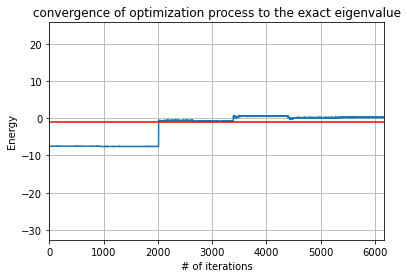

In [44]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [45]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00, 10.85it/s]
7it [00:00, 11.64it/s]
7it [00:00, 11.53it/s]
7it [00:00, 13.52it/s]
7it [00:00, 13.04it/s]
7it [00:00, 13.47it/s]
7it [00:00, 12.28it/s]
7it [00:00, 12.65it/s]
7it [00:00, 12.22it/s]
7it [00:00, 12.38it/s]
7it [00:00, 13.28it/s]
7it [00:00, 11.67it/s]
7it [00:00, 13.45it/s]
7it [00:00, 12.25it/s]
7it [00:00, 13.05it/s]
7it [00:00, 11.65it/s]
7it [00:00, 12.27it/s]
7it [00:00, 13.89it/s]
7it [00:00, 11.50it/s]
7it [00:00, 13.26it/s]
7it [00:00, 13.18it/s]
7it [00:00, 12.74it/s]
7it [00:00, 11.86it/s]
7it [00:00, 11.99it/s]
7it [00:00, 12.55it/s]
7it [00:00, 12.27it/s]
7it [00:00, 10.13it/s]
7it [00:00, 14.03it/s]
7it [00:00, 13.27it/s]
7it [00:00, 13.40it/s]
7it [00:00, 11.46it/s]
7it [00:00, 10.88it/s]
7it [00:00, 13.33it/s]
7it [00:00, 13.78it/s]
7it [00:00, 12.65it/s]
7it [00:00, 12.84it/s]
7it [00:00, 13.40it/s]
7it [00:00, 11.98it/s]
7it [00:00, 12.08it/s]
7it [00:00, 11.17it/s]
7it [00:00, 14.42it/s]
7it [00:00, 10.19it/s]
7it [00:00, 10.33it/s]
7it [00:00,

7it [00:00, 12.64it/s]
7it [00:00, 13.07it/s]
7it [00:00, 12.80it/s]
7it [00:00, 11.29it/s]
7it [00:00, 13.00it/s]
7it [00:00, 14.25it/s]
7it [00:00, 14.88it/s]
7it [00:00, 14.36it/s]
7it [00:00, 13.02it/s]
7it [00:00, 12.74it/s]
7it [00:00, 15.06it/s]
7it [00:00, 12.31it/s]
7it [00:00, 12.75it/s]
7it [00:00, 12.74it/s]
7it [00:00, 12.73it/s]
7it [00:00, 14.50it/s]
7it [00:00, 13.56it/s]
7it [00:00, 12.54it/s]
7it [00:00, 11.44it/s]
7it [00:00, 13.99it/s]
7it [00:00, 13.82it/s]
7it [00:00, 12.67it/s]
7it [00:00, 13.36it/s]
7it [00:00, 12.92it/s]
7it [00:00, 13.48it/s]
7it [00:00, 11.78it/s]
7it [00:00, 12.37it/s]
7it [00:00, 12.48it/s]
7it [00:00, 13.51it/s]
7it [00:00, 14.30it/s]
7it [00:00, 13.61it/s]
7it [00:00, 12.43it/s]
7it [00:00, 13.73it/s]
7it [00:00, 12.09it/s]
7it [00:00, 12.85it/s]
7it [00:00, 11.43it/s]
7it [00:00, 11.65it/s]
7it [00:00, 13.14it/s]
7it [00:00, 11.58it/s]
7it [00:00, 11.93it/s]
7it [00:00, 11.65it/s]
7it [00:00, 12.03it/s]
7it [00:00, 11.14it/s]
7it [00:00,

         Current function value: 0.275450
         Iterations: 2
         Function evaluations: 561
         Gradient evaluations: 22
[4.59399592 2.07473638 1.47258248 2.57478159 3.588041   4.78415207
 2.53454743 2.75738901 3.89616332 5.33781189 1.26937787 2.92271282
 5.61618787 3.21760814 3.96590021 0.29064804 0.51383411 5.36139162
 4.81071985 2.163071   0.53378448 0.98062874 5.96721045 5.86927266]


7it [00:00, 13.26it/s]

CPU times: total: 5min 3s
Wall time: 5min 10s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.2874704245591102

Approximation Error
0.7462100872311831


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


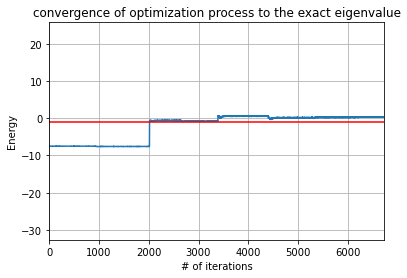

In [46]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [47]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [48]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [49]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 20.99it/s]
3it [00:00, 19.45it/s]
3it [00:00, 18.48it/s]
3it [00:00, 22.33it/s]
3it [00:00, 23.29it/s]
3it [00:00, 29.14it/s]
3it [00:00, 17.25it/s]
3it [00:00, 18.05it/s]
3it [00:00, 19.09it/s]
3it [00:00, 19.73it/s]
3it [00:00, 10.59it/s]
3it [00:00, 12.83it/s]
3it [00:00, 11.51it/s]
3it [00:00, 13.50it/s]
3it [00:00, 13.13it/s]
3it [00:00, 13.17it/s]
3it [00:00, 14.15it/s]
3it [00:00, 13.48it/s]
3it [00:00, 13.41it/s]
3it [00:00, 12.75it/s]
3it [00:00, 12.79it/s]
3it [00:00, 13.50it/s]
3it [00:00, 14.62it/s]
3it [00:00, 14.22it/s]
3it [00:00, 14.98it/s]
3it [00:00, 15.45it/s]
3it [00:00, 17.64it/s]
3it [00:00, 14.66it/s]
3it [00:00, 16.63it/s]
3it [00:00, 16.25it/s]
3it [00:00, 13.96it/s]
3it [00:00, 13.98it/s]
3it [00:00, 17.73it/s]
3it [00:00, 22.16it/s]
3it [00:00, 19.16it/s]
3it [00:00, 18.81it/s]
3it [00:00, 23.79it/s]
3it [00:00, 22.36it/s]
3it [00:00, 23.02it/s]
3it [00:00, 23.82it/s]
3it [00:00, 20.28it/s]
3it [00:00, 26.78it/s]
3it [00:00, 26.16it/s]
3it [00:00,

3it [00:00, 12.86it/s]
3it [00:00, 16.97it/s]
3it [00:00, 15.98it/s]
3it [00:00, 13.59it/s]
3it [00:00, 16.65it/s]
3it [00:00, 19.57it/s]
3it [00:00, 11.73it/s]
3it [00:00, 15.85it/s]
3it [00:00, 15.02it/s]
3it [00:00, 14.81it/s]
3it [00:00, 13.89it/s]
3it [00:00, 14.95it/s]
3it [00:00, 15.75it/s]
3it [00:00, 11.55it/s]
3it [00:00, 14.11it/s]
3it [00:00, 19.01it/s]
3it [00:00, 15.25it/s]
3it [00:00, 15.49it/s]
3it [00:00, 15.16it/s]
3it [00:00, 13.96it/s]
3it [00:00, 16.25it/s]
3it [00:00, 18.84it/s]
3it [00:00, 14.80it/s]
3it [00:00, 16.53it/s]
3it [00:00, 10.51it/s]
3it [00:00, 12.66it/s]
3it [00:00, 12.05it/s]
3it [00:00, 12.71it/s]
3it [00:00, 10.26it/s]
3it [00:00, 13.02it/s]
3it [00:00, 12.38it/s]
3it [00:00, 11.72it/s]
3it [00:00, 11.34it/s]
3it [00:00, 14.40it/s]
3it [00:00, 13.36it/s]
3it [00:00, 12.76it/s]
3it [00:00, 12.20it/s]
3it [00:00, 10.90it/s]
3it [00:00, 12.66it/s]
3it [00:00, 18.92it/s]
3it [00:00, 13.77it/s]
3it [00:00, 12.78it/s]
3it [00:00, 15.71it/s]
3it [00:00,

         Current function value: -0.274825
         Iterations: 3
         Function evaluations: 444
         Gradient evaluations: 25
[2.63182907 3.20241488 1.05283041 2.59960457 3.19653894 5.06323638
 4.1107361  1.68452885 2.23011236 4.66712293 3.8588647  4.13031329
 1.00231919 5.15889989 2.76818601 1.22587102]


3it [00:00, 15.91it/s]

CPU times: total: 1min 46s
Wall time: 1min 57s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.24896139623091382

Approximation Error
0.757577822928631


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


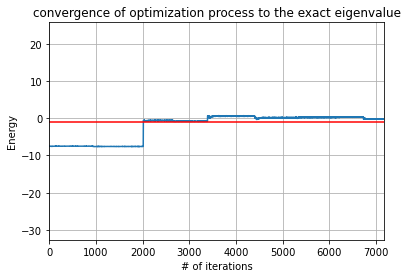

In [50]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [51]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 14.17it/s]
3it [00:00, 14.03it/s]
3it [00:00, 11.60it/s]
3it [00:00, 12.51it/s]
3it [00:00, 13.49it/s]
3it [00:00, 11.00it/s]
3it [00:00, 10.32it/s]
3it [00:00, 13.21it/s]
3it [00:00, 15.11it/s]
3it [00:00, 16.33it/s]
3it [00:00, 15.18it/s]
3it [00:00, 13.21it/s]
3it [00:00, 12.53it/s]
3it [00:00, 15.27it/s]
3it [00:00, 12.36it/s]
3it [00:00, 12.78it/s]
3it [00:00, 16.85it/s]
3it [00:00, 13.47it/s]
3it [00:00, 10.73it/s]
3it [00:00, 12.64it/s]
3it [00:00, 12.79it/s]
3it [00:00, 17.22it/s]
3it [00:00, 13.16it/s]
3it [00:00, 15.40it/s]
3it [00:00, 13.99it/s]
3it [00:00, 15.28it/s]
3it [00:00, 19.74it/s]
3it [00:00, 17.47it/s]
3it [00:00, 11.56it/s]
3it [00:00, 13.54it/s]
3it [00:00, 11.30it/s]
3it [00:00, 12.93it/s]
3it [00:00, 17.75it/s]
3it [00:00, 13.93it/s]
3it [00:00, 14.46it/s]
3it [00:00, 12.71it/s]
3it [00:00,  9.36it/s]
3it [00:00, 10.62it/s]
3it [00:00, 10.23it/s]
3it [00:00, 11.47it/s]
3it [00:00, 12.49it/s]
3it [00:00, 12.80it/s]
3it [00:00, 11.13it/s]
3it [00:00,

3it [00:00, 17.48it/s]
3it [00:00, 14.99it/s]
3it [00:00, 14.39it/s]
3it [00:00, 12.69it/s]
3it [00:00, 11.90it/s]
3it [00:00, 13.10it/s]
3it [00:00, 16.67it/s]
3it [00:00, 15.36it/s]
3it [00:00, 11.06it/s]
3it [00:00, 13.96it/s]
3it [00:00, 14.89it/s]
3it [00:00, 11.05it/s]
3it [00:00, 13.83it/s]
3it [00:00, 16.59it/s]
3it [00:00, 15.30it/s]
3it [00:00, 14.10it/s]
3it [00:00, 20.59it/s]
3it [00:00, 11.56it/s]
3it [00:00, 10.86it/s]
3it [00:00, 18.95it/s]
3it [00:00, 13.97it/s]
3it [00:00, 13.43it/s]
3it [00:00, 15.77it/s]
3it [00:00, 25.10it/s]
3it [00:00, 16.58it/s]
3it [00:00, 13.72it/s]
3it [00:00, 20.39it/s]
3it [00:00, 14.28it/s]
3it [00:00, 10.86it/s]
3it [00:00, 17.11it/s]
3it [00:00,  9.50it/s]
3it [00:00,  8.42it/s]
3it [00:00, 10.28it/s]
3it [00:00, 12.76it/s]
3it [00:00, 14.44it/s]
3it [00:00, 13.94it/s]
3it [00:00, 13.77it/s]
3it [00:00, 12.36it/s]
3it [00:00, 12.86it/s]
3it [00:00, 14.44it/s]
3it [00:00, 12.79it/s]
3it [00:00, 11.57it/s]
3it [00:00, 11.60it/s]
3it [00:00,

         Current function value: -0.166229
         Iterations: 0
         Function evaluations: 403
         Gradient evaluations: 23
[2.43025205 0.46301302 0.93260488 4.27873708 2.4598961  4.0643742
 2.27471023 6.12264196 1.9996709  2.03799265 1.60632696 4.3700936
 1.80092575 4.7471822  3.67614181 1.89345137]


3it [00:00, 10.29it/s]

CPU times: total: 1min 29s
Wall time: 1min 32s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.15345647857563005

Approximation Error
0.8505742087520041


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


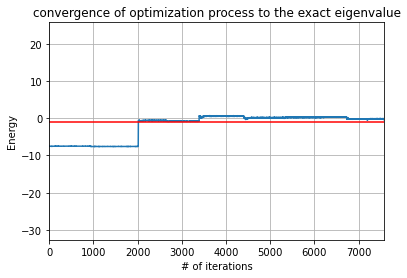

In [52]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [53]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [54]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 12.68it/s]
4it [00:00, 11.37it/s]
4it [00:00, 15.12it/s]
4it [00:00, 10.78it/s]
4it [00:00, 13.90it/s]
4it [00:00, 10.20it/s]
4it [00:00, 15.69it/s]
4it [00:00, 13.11it/s]
4it [00:00, 11.66it/s]
4it [00:00, 12.31it/s]
4it [00:00, 12.26it/s]
4it [00:00, 14.83it/s]
4it [00:00, 13.21it/s]
4it [00:00, 11.94it/s]
4it [00:00, 10.62it/s]
4it [00:00, 13.05it/s]
4it [00:00, 10.88it/s]
4it [00:00, 18.41it/s]
4it [00:00, 13.30it/s]
4it [00:00, 13.59it/s]
4it [00:00, 14.84it/s]
4it [00:00, 12.59it/s]
4it [00:00, 15.52it/s]
4it [00:00, 15.58it/s]
4it [00:00, 14.91it/s]
4it [00:00, 11.70it/s]
4it [00:00, 11.13it/s]
4it [00:00, 11.77it/s]
4it [00:00, 12.69it/s]
4it [00:00, 12.13it/s]
4it [00:00, 12.69it/s]
4it [00:00, 12.34it/s]
4it [00:00,  9.78it/s]
4it [00:00, 16.39it/s]
4it [00:00, 15.06it/s]
4it [00:00, 16.56it/s]
4it [00:00, 15.99it/s]
4it [00:00, 12.15it/s]
4it [00:00, 20.10it/s]
4it [00:00, 16.00it/s]
4it [00:00, 17.08it/s]
4it [00:00, 16.39it/s]
4it [00:00, 13.01it/s]
4it [00:00,

4it [00:00, 10.69it/s]
4it [00:00, 14.63it/s]
4it [00:00, 10.96it/s]
4it [00:00, 13.32it/s]
4it [00:00, 12.82it/s]
4it [00:00, 13.65it/s]
4it [00:00, 13.42it/s]
4it [00:00, 13.98it/s]
4it [00:00, 12.52it/s]
4it [00:00, 13.33it/s]
4it [00:00, 12.66it/s]
4it [00:00, 11.87it/s]
4it [00:00, 14.25it/s]
4it [00:00, 11.72it/s]
4it [00:00, 12.76it/s]
4it [00:00, 13.04it/s]
4it [00:00, 19.74it/s]
4it [00:00, 15.28it/s]
4it [00:00, 15.82it/s]
4it [00:00, 16.74it/s]
4it [00:00, 13.61it/s]
4it [00:00, 14.60it/s]
4it [00:00, 12.96it/s]
4it [00:00, 13.70it/s]
4it [00:00, 17.57it/s]
4it [00:00, 15.34it/s]
4it [00:00, 13.25it/s]
4it [00:00, 15.25it/s]
4it [00:00, 14.02it/s]
4it [00:00, 13.10it/s]
4it [00:00, 12.20it/s]
4it [00:00, 13.71it/s]
4it [00:00, 14.36it/s]
4it [00:00, 16.49it/s]
4it [00:00, 14.99it/s]
4it [00:00, 14.19it/s]
4it [00:00, 16.22it/s]
4it [00:00, 14.99it/s]
4it [00:00, 16.02it/s]
4it [00:00, 13.13it/s]
4it [00:00, 15.85it/s]
4it [00:00, 14.94it/s]
4it [00:00, 12.31it/s]
4it [00:00,

         Current function value: -0.726960
         Iterations: 1
         Function evaluations: 453
         Gradient evaluations: 26
[4.46717013 1.4798859  0.02888709 5.8066834  1.61911325 5.6853463
 3.79382147 2.93153743 2.18655272 1.76092079 3.27790332 3.96564102
 3.0829428  0.80012895 1.62193967 2.36093695]


4it [00:00, 13.70it/s]

CPU times: total: 2min 8s
Wall time: 2min 13s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.7260961233256018

Approximation Error
0.27759299604915616


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


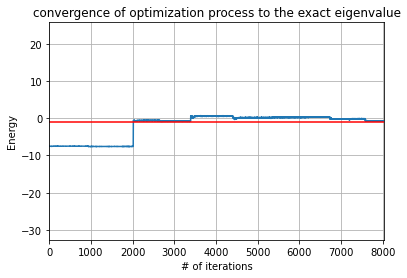

In [55]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [56]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 18.70it/s]
4it [00:00, 17.75it/s]
4it [00:00, 18.00it/s]
4it [00:00, 11.69it/s]
4it [00:00, 18.00it/s]
4it [00:00, 18.96it/s]
4it [00:00, 15.82it/s]
4it [00:00, 18.07it/s]
4it [00:00, 19.81it/s]
4it [00:00, 13.59it/s]
4it [00:00, 16.22it/s]
4it [00:00, 17.28it/s]
4it [00:00, 19.32it/s]
4it [00:00, 19.77it/s]
4it [00:00, 15.86it/s]
4it [00:00, 11.68it/s]
4it [00:00, 19.88it/s]
4it [00:00, 17.18it/s]
4it [00:00, 18.08it/s]
4it [00:00, 17.16it/s]
4it [00:00, 14.84it/s]
4it [00:00, 13.75it/s]
4it [00:00, 14.39it/s]
4it [00:00, 14.59it/s]
4it [00:00, 14.97it/s]
4it [00:00, 15.77it/s]
4it [00:00, 13.88it/s]
4it [00:00, 13.22it/s]
4it [00:00, 14.64it/s]
4it [00:00, 13.34it/s]
4it [00:00, 16.19it/s]
4it [00:00, 14.72it/s]
4it [00:00, 12.32it/s]
4it [00:00, 13.77it/s]
4it [00:00, 15.34it/s]
4it [00:00, 19.32it/s]
4it [00:00, 20.82it/s]
4it [00:00, 22.81it/s]
4it [00:00, 17.50it/s]
4it [00:00, 15.42it/s]
4it [00:00, 19.01it/s]
4it [00:00, 18.23it/s]
4it [00:00, 17.93it/s]
4it [00:00,

4it [00:00, 13.18it/s]
4it [00:00, 20.05it/s]
4it [00:00, 16.51it/s]
4it [00:00, 15.75it/s]
4it [00:00, 17.69it/s]
4it [00:00, 15.10it/s]
4it [00:00, 11.31it/s]
4it [00:00, 13.72it/s]
4it [00:00, 15.50it/s]
4it [00:00, 16.16it/s]
4it [00:00, 13.52it/s]
4it [00:00, 14.89it/s]
4it [00:00, 13.82it/s]
4it [00:00, 15.15it/s]
4it [00:00, 14.05it/s]
4it [00:00, 12.11it/s]
4it [00:00, 14.94it/s]
4it [00:00, 17.00it/s]
4it [00:00, 16.42it/s]
4it [00:00, 15.55it/s]
4it [00:00, 13.25it/s]
4it [00:00, 16.20it/s]
4it [00:00, 15.48it/s]
4it [00:00, 12.58it/s]
4it [00:00, 14.27it/s]
4it [00:00, 13.11it/s]
4it [00:00, 16.27it/s]
4it [00:00, 12.52it/s]
4it [00:00, 14.37it/s]
4it [00:00, 17.36it/s]
4it [00:00, 16.43it/s]
4it [00:00, 17.00it/s]
4it [00:00, 10.92it/s]
4it [00:00, 16.34it/s]
4it [00:00, 14.29it/s]
4it [00:00, 13.95it/s]
4it [00:00, 14.34it/s]
4it [00:00, 12.91it/s]
4it [00:00, 15.71it/s]
4it [00:00, 11.74it/s]
4it [00:00, 18.62it/s]
4it [00:00, 12.68it/s]
4it [00:00, 18.72it/s]
4it [00:00,

         Current function value: -0.648498
         Iterations: 0
         Function evaluations: 403
         Gradient evaluations: 23
[0.56768386 4.14286808 5.87868854 4.69594253 0.73445163 4.89523382
 6.25730699 4.06481546 0.6055673  2.27442461 5.7078626  4.72980104
 1.42470213 4.64754414 1.27647634 5.92988779]


4it [00:00, 14.53it/s]

CPU times: total: 1min 58s
Wall time: 2min 3s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.6229572071530769

Approximation Error
0.38020788825058355


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


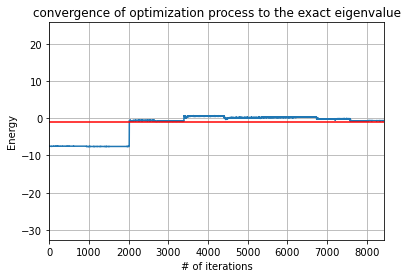

In [57]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)